# Social Media Analytics

Master's Degree in Data Science (A.Y. 2021/2022)

In [1]:
!pip install demoji

     |████████████████████████████████| 42 kB 701 kB/s 


In [2]:
!pip install NRCLex

     |████████████████████████████████| 396 kB 5.1 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=6e2854ca2df4c7b5cc599d8276d29f79cb9aa934319713aaec7f6546c1dda160
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [3]:
!pip install igraph

     |████████████████████████████████| 3.1 MB 5.0 MB/s 


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy import stats
from operator import itemgetter
import itertools 
from networkx.algorithms.community.centrality import girvan_newman
import networkx as nx
import igraph
import demoji
import re
import string
import unicodedata
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nrclex import NRCLex

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

sns.set()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Caricamento dati Olimpiadi

In [5]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Load data
df_list = []
path='gdrive/MyDrive/Social Media Analytics/Tweets/olimpiadi'
for file in os.listdir(path):
        df_list.append(pd.read_json(path + '/' + file))

In [7]:
# Concatenate days
tweets = pd.concat(df_list, ignore_index=True)

In [ ]:
tweets.head()

,Datetime,TweetId,Text,Username,UserVerified,UserId,UserFollowers,ReplyCount,RetweetCount,LikeCount,QuoteCount,Language,Retweeted,Quoted,Mentioned
0,2021-08-07 23:59:59,1424158410791079948,It's Eliud Kipchoge's world... #Tokyo2020 http...,EarlAuthours,False,154451972,2185,0,0,2,1,en,NaN,SkyEnda,None
1,2021-08-07 23:59:58,1424158408824000518,I choose to see a smile on Eliud Kipchoge's fa...,dnkoni,False,338870984,5834,1,0,8,0,en,NaN,None,None
2,2021-08-07 23:59:55,1424158393539911686,Eliud Kipchoge will win the gold medal and its...,SekyereRichard_,False,1412008641725669377,19,0,0,2,0,en,NaN,None,None
3,2021-08-07 23:59:41,1424158333787901954,It’s insane how relaxed Kipchoge looks #Tokyo2...,OmarDXB,False,25084590,7095,0,0,0,0,en,NaN,None,None
4,2021-08-07 23:59:40,1424158333276016644,#Athletics \n\nThrough 35km two Irishmen still...,TeamIreland,True,23585776,65542,2,10,138,1,en,NaN,None,None


In [8]:
print('Sono presenti {0} tweet'.format(str(len(tweets))))

Sono presenti 897252 tweet


### Esplorazione dataset

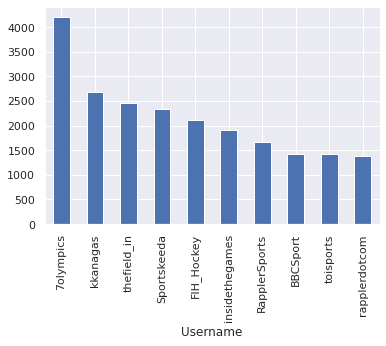

In [ ]:
# Users by tweets count
plt.figure(figsize=(6,4))
tweets.groupby('Username').count().sort_values(by='Datetime', ascending=False)['Datetime'][0:10].plot.bar()

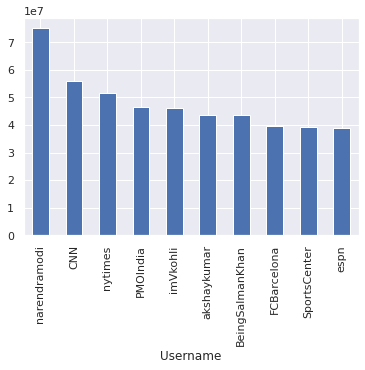

In [ ]:
# Users by followers count
plt.figure(figsize=(6,4))
tweets.groupby('Username')['UserFollowers'].max().sort_values(ascending=False)[0:10].plot.bar()

In [ ]:
# Tweets by likes count
tweets.sort_values(by='LikeCount', ascending=False).head()

,Datetime,TweetId,Text,Username,UserVerified,UserId,UserFollowers,ReplyCount,RetweetCount,LikeCount,QuoteCount,Language,Retweeted,Quoted,Mentioned
573550,2021-07-24 08:50:50,1418856186980470794,I am really happy on winning silver medal in #...,mirabai_chanu,True,997046099088166912,351207,11640,50265,259238,4422,en,NaN,None,None
32666,2021-08-07 12:51:20,1423990141966761987,Realised my unfinished dream today after 37 ye...,PTUshaOfficial,True,763250974085361665,119748,1708,30985,246867,1233,en,NaN,None,[Neeraj_chopra1]
244694,2021-08-08 16:32:20,1424408145804218369,Congratulations to all our winners and partici...,imVkohli,True,71201743,46233847,2124,14165,194716,326,en,NaN,None,None
46995,2021-08-07 12:20:08,1423982290296721411,History has been scripted at Tokyo! What @Neer...,narendramodi,True,18839785,75043638,5902,37548,179391,1460,en,NaN,Olympics,[Neeraj_chopra1]
589585,2021-07-24 06:39:41,1418823182702694400,Could not have asked for a happier start to @T...,narendramodi,True,18839785,75057642,3811,26900,173975,1515,en,NaN,None,"[Tokyo2020, mirabai_chanu]"


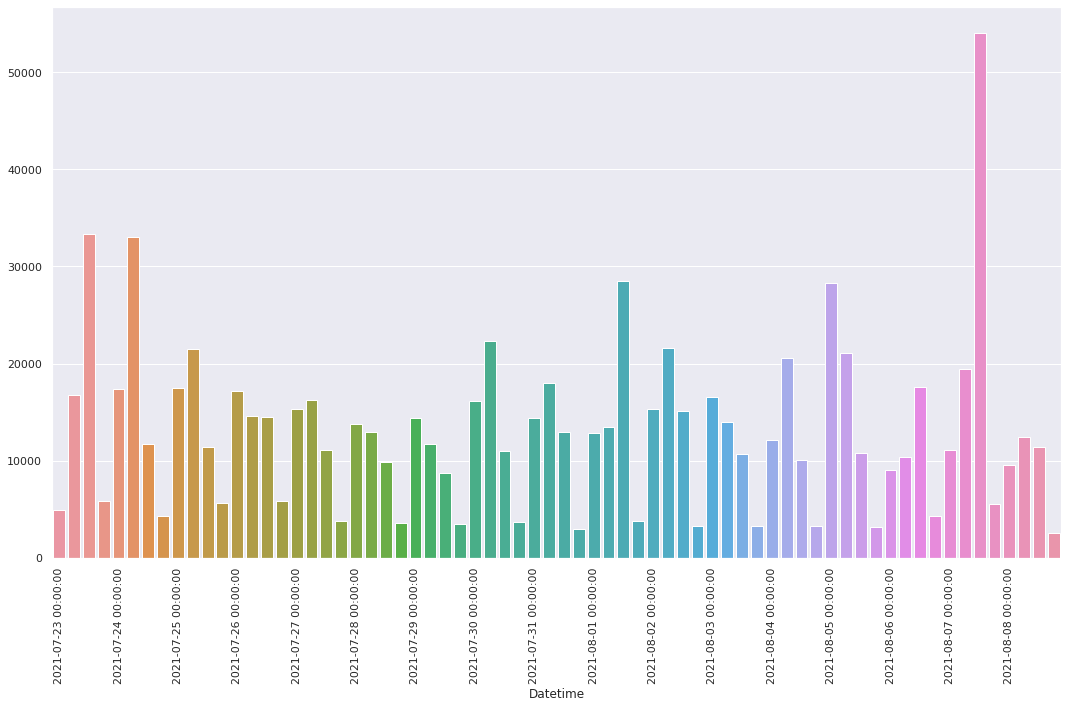

In [ ]:
# Tweets count by date (6H slice)
dates = tweets.groupby(pd.Grouper(key='Datetime', freq='6H'))['Text'].count().index
x = []
for date in dates:
        x.append(str(date.date()))
y = tweets.groupby(pd.Grouper(key='Datetime', freq='6H'))['Text'].count().values
plt.figure(figsize=(15, 10))
bar_plot = sns.barplot(x = dates, y= y)
plt.xticks(rotation=90)

# Plot x label once every 4 tic
for index, label in enumerate(bar_plot.get_xticklabels()):
    if index % 4 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.tight_layout()

## Social Network Analysis

In [ ]:
df_net = tweets[['Username', 'Retweeted', 'Quoted', 'Mentioned']].dropna(axis=0, how='all', subset=['Retweeted', 'Quoted', 'Mentioned']).copy()

In [ ]:
df_net

,Username,Retweeted,Quoted,Mentioned
0,EarlAuthours,NaN,SkyEnda,None
5,BBCSport,NaN,None,"[BBCiPlayer, BBCSport]"
7,ghaimp,NaN,None,[Neeraj_chopra1]
10,Kevinfinity7,NaN,overtime,None
14,kujijengake,NaN,None,[EliudKipchoge]
...,...,...,...,...
897236,ESPNAsia,NaN,None,[Olympics]
897242,Tennis,NaN,None,[Olympics]
897243,aleaguewomen,NaN,None,"[TheMatildas, TeamGB]"
897250,CBPost_Jeremy,NaN,None,"[Olympics, SwimmingCanada, mags_swims26]"


In [ ]:
# Build the graph
G = nx.Graph()
for i in range(len(df_net)):
  if (df_net['Quoted'].iloc[i] is not None) and (df_net['Username'].iloc[i]!=df_net['Quoted'].iloc[i]):
    G.add_edge(df_net['Username'].iloc[i], df_net['Quoted'].iloc[i])

In [ ]:
# Largest connected subgraph
largest_subgraph = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)

In [ ]:
# Save graph
nx.write_gexf(largest_subgraph, "/content/gdrive/MyDrive/Social Media Analytics/olympics.gexf")

### Analisi del grafo

In [ ]:
print(f"Il grafo ha {G.number_of_nodes()} nodi e {G.number_of_edges()} archi")

Il grafo ha 55241 nodi e 65099 archi


In [ ]:
degrees = [val for (node, val) in G.degree()]

In [ ]:
print(f"Il nodo con grado massimo di G è '{list(G.nodes)[np.argmax(degrees)]}', corrispondente al valore {np.max(degrees)}")   
print(f"Il grado minimo di G è  {np.min(degrees)}")  

Il nodo con grado massimo di G è 'Olympics', corrispondente al valore 4187
Il grado minimo di G è  1


In [ ]:
print(f"Il grado medio dei nodi di G è {np.mean(degrees):.1f}")  
print(f"Il grado più frequente dei nodi di G è {stats.mode(degrees)[0][0]}") 

Il grado medio dei nodi di G è 2.4
Il grado più frequente dei nodi di G è 1


In [ ]:
if nx.is_connected(G):
    print("Il grafo è connesso")
else:
    print("Il grafo non è connesso")

Il grafo non è connesso


In [ ]:
print(f"Ci sono {nx.number_connected_components(G)} componenti connesse in G")  

Ci sono 5771 componenti connesse in G


In [ ]:
print(f"Ci sono {largest_subgraph.number_of_nodes()} nodi e {largest_subgraph.number_of_edges()} \
archi nella più grande componente connessa di G")

Ci sono 41960 nodi e 57579 archi nella più grande componente connessa di G


In [ ]:
print(f"Il coefficiente di clustering medio è {nx.average_clustering(G)} all'interno di G")
print(f"La transitività all'interno di G {nx.transitivity(G)}")

Il coefficiente di clustering medio è 0.015090755794676504 all'interno di G
La transitività all'interno di G 0.0005447158049480247


In [ ]:
print(f"Il coefficiente di clustering medio è {nx.average_clustering(largest_subgraph)} all'interno della componente connessa più grande di G")
print(f"La transitività all'interno della componente connessa più grande di G {nx.transitivity(largest_subgraph)}")

Il coefficiente di clustering medio è 0.01956693138354921 all'interno della componente connessa più grande di G
La transitività all'interno della componente connessa più grande di G 0.0005439871952527468


In [ ]:
top5degree = np.argpartition(degrees, -5)[-5:]
for ind in top5degree:
  print(f"Degree centrality di '{list(G.nodes)[ind]}': {nx.degree_centrality(largest_subgraph)[list(G.nodes)[ind]]}")  
print('-----------------------------------------------')
for ind in top3degree:
  print(f"Closeness centrality di '{list(G.nodes)[ind]}': {nx.closeness_centrality(largest_subgraph, u=list(G.nodes)[ind])}")  

Degree centrality di 'BBCSport': 0.026001572964083987
Degree centrality di 'TeamGB': 0.030958793107557378
Degree centrality di 'Tokyo2020': 0.04020591529826736
Degree centrality di 'OlympicKhel': 0.044495817345503945
Degree centrality di 'Olympics': 0.0997878881765533
-----------------------------------------------
Closeness centrality di 'BBCSport': 0.2795607939289355
Closeness centrality di 'TeamGB': 0.2759171702691506
Closeness centrality di 'Tokyo2020': 0.306363994801326
Closeness centrality di 'OlympicKhel': 0.283099323271238
Closeness centrality di 'Olympics': 0.33773352543928137


### Community Detection

In [ ]:
g_igraph = igraph.Graph.from_networkx(largest_subgraph)

#### Fast greedy

In [ ]:
c1 = g_igraph.community_fastgreedy()

In [ ]:
num_communities = c1.optimal_count
clusters = c1.as_clustering(num_communities)
communities = clusters.membership

In [ ]:
max(communities)+1

308

In [ ]:
print(clusters.modularity)

0.7841086633410566


#### Louvain

In [ ]:
c2 = g_igraph.community_multilevel()

In [ ]:
communities = c2.membership

In [ ]:
max(communities)+1

88

In [ ]:
print(c2.modularity)

0.7967108369825874


#### Leadeing eigenvector

In [ ]:
c3 = g_igraph.community_leading_eigenvector()

In [ ]:
communities = c3.membership

In [ ]:
max(communities)+1

17

In [ ]:
print(c3.modularity)

0.44563264204271386


#### Walktrap

In [ ]:
c4 = g_igraph.community_walktrap()

In [ ]:
num_communities = c4.optimal_count
clusters = c4.as_clustering(num_communities)
communities = clusters.membership

In [ ]:
max(communities)+1

1581

In [ ]:
print(clusters.modularity)

0.7079253913518961


### Assortativity


In [ ]:
g_igraph.assortativity_degree()

-0.12277736583234444

## Social Content Analysis

### Preprocessing

In [ ]:
df_sentiment = tweets[['Datetime', 'Text']].copy()

In [ ]:
####################################
# Functions for data preprocessing #
####################################

# Replace emojis with their description
def replace_emoji(text):
  return demoji.replace_with_desc(text," ")
  

# Replace compact forms with complete forms
def replace_words(data_text):
    data_text = data_text.replace('\n','').\
                                      replace('won\'t','will not').\
                                      replace('n\'t',' not').\
                                      replace('\'d',' would').\
                                      replace('\'s',' is').\
                                      replace('\'m',' am').\
                                      replace('\'ll',' will').\
                                      replace('\'ve',' have').\
                                      replace('\'re',' are').\
                                      replace('ying','y').\
                                      replace('<br/>','')
    
    return data_text

# Remove URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Remove numbers and symbols
def remove_num_symb(data):
    data = data.replace('[^\w\s]',' ').\
              replace('\.',' ').\
              replace('\d+',' ')
    return data

# Remove stop words
def remove_stopwords(text, stop_words=None):
    if stop_words is None:
        stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

# Remove extra spaces
def remove_extra_whitespace(text):
    return " ".join(text.split())

# Remove punctuation
def remove_punctuation(text, punctuation=None):
  if punctuation is None:
      punctuation = string.punctuation
  return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))


# POS tagging
def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

# Lemmatizzation
def lemmaSentence(text, lemmatizer):
    lemma_text = ''
    tok_text = word_tokenize(text)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

In [ ]:
def preprocess(text):
    text = text.lower()
    text = remove_urls(text)
    text = replace_words(text)
    text = replace_emoji(text)
    text = text.lower()
    # Remove words that are digits only
    text = re.sub(r'\b\d+\b', '', text)
    text = remove_extra_whitespace(text)
    text = remove_punctuation(text)
    text = remove_num_symb(text)
    text = remove_stopwords(text)

    # Lemmatization with POS tagging
    text = lemmaSentence(text, WordNetLemmatizer())

    return text

In [ ]:
df_sentiment['Preprocessed']=df_sentiment['Text'].apply(preprocess)

In [ ]:
df_sentiment.dropna(axis=0, inplace=True)

In [ ]:
df_sentiment.head()

,Datetime,Text,Preprocessed
0,2021-08-07 23:59:59,It's Eliud Kipchoge's world... #Tokyo2020 http...,eliud kipchoge world tokyo2020
1,2021-08-07 23:59:58,I choose to see a smile on Eliud Kipchoge's fa...,choose see smile eliud kipchoge face marathon ...
2,2021-08-07 23:59:55,Eliud Kipchoge will win the gold medal and its...,eliud kipchoge win gold medal certain 1st plac...
3,2021-08-07 23:59:41,It’s insane how relaxed Kipchoge looks #Tokyo2...,it ’ s insane relax kipchoge look tokyo2020 ol...
4,2021-08-07 23:59:40,#Athletics \n\nThrough 35km two Irishmen still...,athletics 35km two irishman still battle field...


### Sentiment Analysis

In [ ]:
# Vader sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
df_sentiment['Sentiment'] = df_sentiment['Preprocessed'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [ ]:
# Emotion extractor
def extract_emotions(text):
  emotions = []
  if TextBlob(text).sentiment.subjectivity > 0:
    for emotion in NRCLex(text).top_emotions:
      emotions.append(emotion[0])
  return emotions

In [ ]:
df_sentiment['Emotions'] = df_sentiment['Preprocessed'].apply(extract_emotions)

In [ ]:
df_sentiment.to_json('/content/gdrive/MyDrive/Social Media Analytics/olympics.json')

In [ ]:
df_sentiment = pd.read_json('/content/gdrive/MyDrive/Social Media Analytics/olympics.json')

In [ ]:
df_sentiment.head()

,Datetime,Text,Preprocessed,Sentiment,Emotions
0,2021-08-07 23:59:59,It's Eliud Kipchoge's world... #Tokyo2020 http...,eliud kipchoge world tokyo2020,0.0000,[]
1,2021-08-07 23:59:58,I choose to see a smile on Eliud Kipchoge's fa...,choose see smile eliud kipchoge face marathon ...,0.3612,"[trust, surprise, positive, joy]"
2,2021-08-07 23:59:55,Eliud Kipchoge will win the gold medal and its...,eliud kipchoge win gold medal certain 1st plac...,0.9022,[positive]
3,2021-08-07 23:59:41,It’s insane how relaxed Kipchoge looks #Tokyo2...,it ’ s insane relax kipchoge look tokyo2020 ol...,0.0516,"[fear, anger, negative]"
4,2021-08-07 23:59:40,#Athletics \n\nThrough 35km two Irishmen still...,athletics 35km two irishman still battle field...,-0.3818,[positive]


In [ ]:
print('Valore di sentiment medio: ' + str(df_sentiment['Sentiment'].mean()))

Valore di sentiment medio: 0.37993024423494387


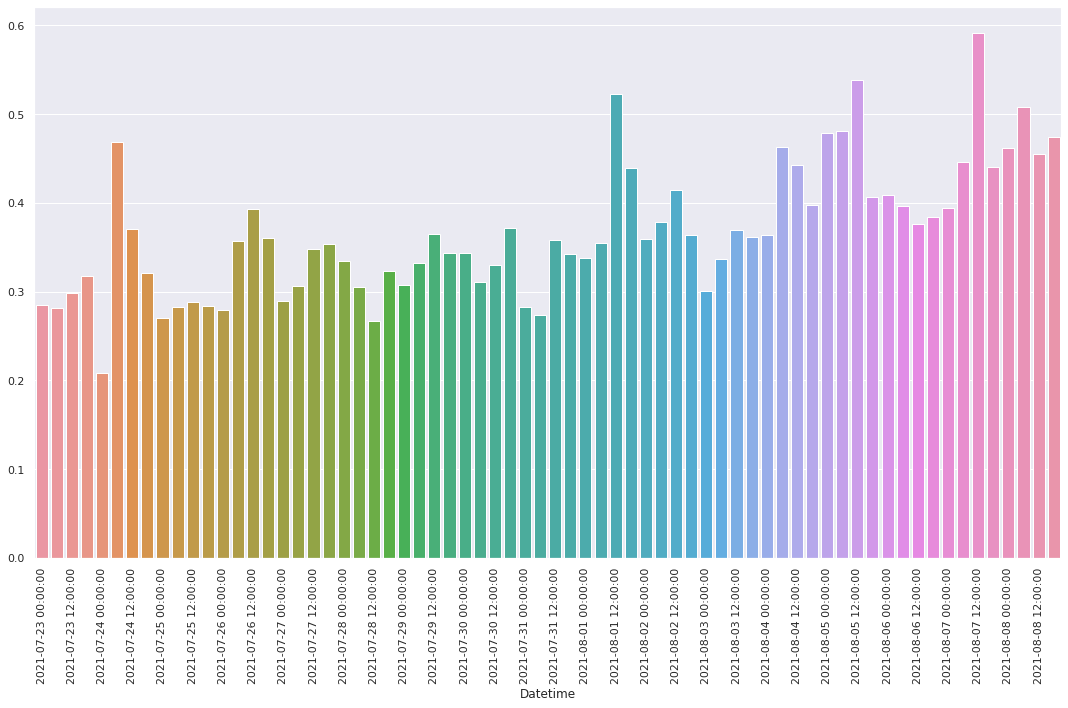

In [ ]:
# Average sentiment value by date (6H slice)
df_sentiment['Datetime'] = pd.to_datetime(df_sentiment['Datetime'])
dates = df_sentiment.groupby(pd.Grouper(key='Datetime', freq='6H'))['Sentiment'].mean().index
x = []
for date in dates:
        x.append(str(date.date()))
y = df_sentiment.groupby(pd.Grouper(key='Datetime', freq='6H'))['Sentiment'].mean().values
plt.figure(figsize=(15, 10))
bar_plot = sns.barplot(x = dates, y= y)
plt.xticks(rotation=90)

for index, label in enumerate(bar_plot.get_xticklabels()):
    if index % 2 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.tight_layout()

### Analisi dei picchi di sentiment

In [ ]:
# Counter emotions
def counter_emotions(df):
  counter = {'anger':0, 'anticipation':0, 'disgust':0, 'fear':0, 'joy':0, 'sadness':0, 'surprise':0, 'trust':0}
  for emotions in df['Emotions'].values:
    for emotion in emotions:
      if emotion in counter:
        counter[emotion] += 1
  return counter

In [ ]:
# Get tweets written during a sentiment peak
df_peak = df_sentiment[(df_sentiment['Datetime']>='2021-07-24 06:00:00') & (df_sentiment['Datetime']<'2021-07-24 12:00:00')].copy()

Mediaglia d'argento India sollevamento pesi

(-0.5, 1023.5, 511.5, -0.5)

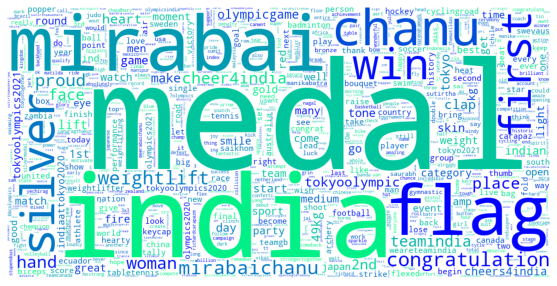

In [ ]:
# Plot wordcloud
fig = plt.figure(figsize=(15, 5))

text = ' '.join(df_peak['Preprocessed'].values)
words = ['tokyo2020', 'olympic', 'olympics']
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=words, collocations=False, width=1024, height=512, colormap='winter')
wcloud = wordcloud.generate_from_text(text)
plt.imshow(wcloud)
plt.axis('off')

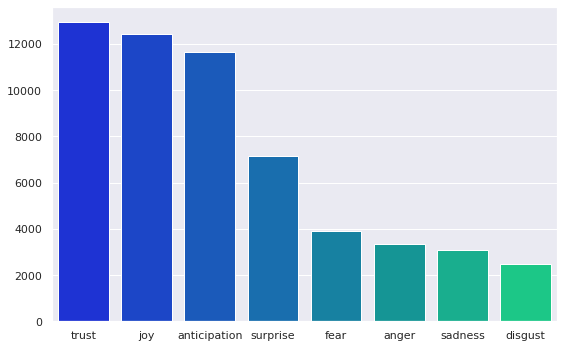

In [ ]:
# Plot barplot emotions
plt.figure(figsize=(8, 5))
emotions = counter_emotions(df_peak)
emotions = dict(sorted(emotions.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x=list(emotions.keys()), y=list(emotions.values()), palette='winter' )
plt.tight_layout()

In [ ]:
# Get tweets written during a sentiment peak
df_peak = df_sentiment[(df_sentiment['Datetime']>='2021-08-01 12:00:00') & (df_sentiment['Datetime']<'2021-08-01 18:00:00')].copy()

Medaglia di bronzo India nel Badminton

(-0.5, 1023.5, 511.5, -0.5)

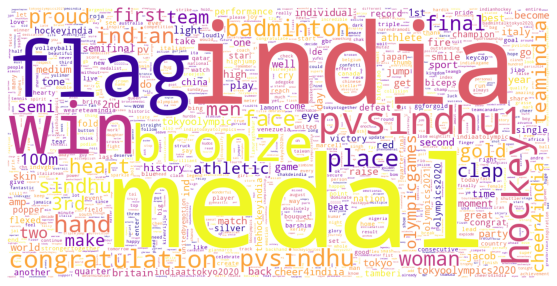

In [ ]:
# Plot wordcloud
fig = plt.figure(figsize=(15, 5))

text = ' '.join(df_peak['Preprocessed'].values)
words = ['tokyo2020', 'olympic', 'olympics']
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=words, collocations=False, width=1024, height=512, colormap='plasma')
wcloud = wordcloud.generate_from_text(text)
plt.imshow(wcloud)
plt.axis('off')

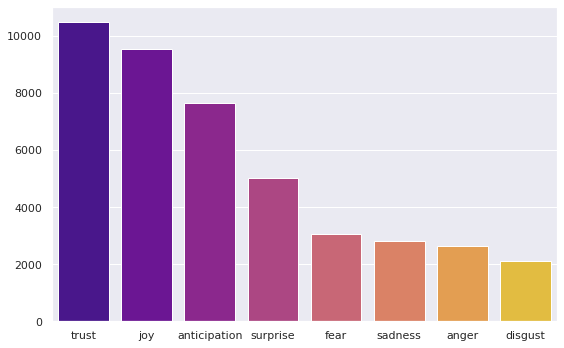

In [ ]:
# Plot barplot emotions
plt.figure(figsize=(8, 5))
emotions = counter_emotions(df_peak)
emotions = dict(sorted(emotions.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x=list(emotions.keys()), y=list(emotions.values()), palette='plasma' )
plt.tight_layout()

In [ ]:
# Get tweets written during a sentiment peak
df_peak = df_sentiment[(df_sentiment['Datetime']>='2021-08-05 12:00:00') & (df_sentiment['Datetime']<'2021-08-05 18:00:00')].copy()

Medaglia d'argento India wrestling

(-0.5, 1023.5, 511.5, -0.5)

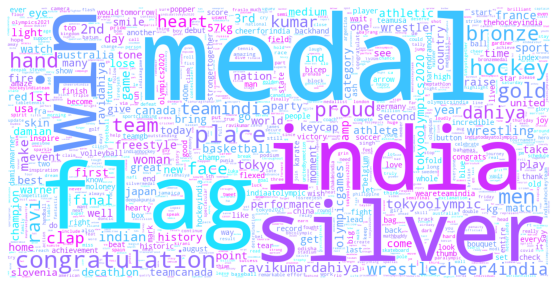

In [ ]:
# Plot wordcloud
fig = plt.figure(figsize=(15, 5))

text = ' '.join(df_peak['Preprocessed'].values)
words = ['tokyo2020', 'olympic', 'olympics']
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=words, collocations=False, width=1024, height=512, colormap='cool')
wcloud = wordcloud.generate_from_text(text)
plt.imshow(wcloud)
plt.axis('off')

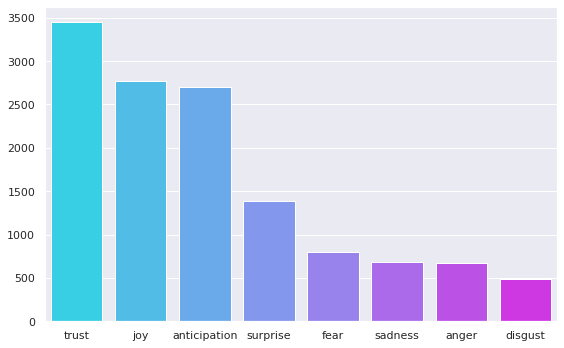

In [ ]:
# Plot barplot emotions
plt.figure(figsize=(8, 5))
emotions = counter_emotions(df_peak)
emotions = dict(sorted(emotions.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x=list(emotions.keys()), y=list(emotions.values()), palette='cool' )
plt.tight_layout()

In [ ]:
# Get tweets written during a sentiment peak
df_peak = df_sentiment[(df_sentiment['Datetime']>='2021-08-07 12:00:00') & (df_sentiment['Datetime']<'2021-08-07 18:00:00')].copy()

Medaglia d'oro India giavellotto

(-0.5, 1023.5, 511.5, -0.5)

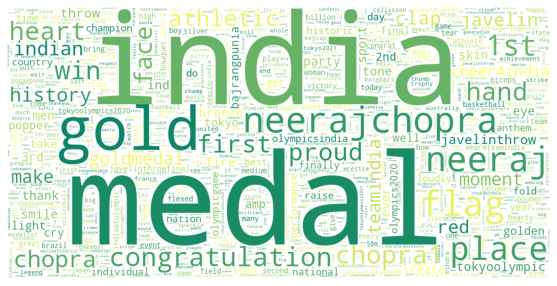

In [ ]:
# Plot wordcloud
fig = plt.figure(figsize=(15, 5))

text = ' '.join(df_peak['Preprocessed'].values)
words = ['tokyo2020', 'olympic', 'olympics']
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=words, collocations=False, width=1024, height=512, colormap='summer')
wcloud = wordcloud.generate_from_text(text)
plt.imshow(wcloud)
plt.axis('off')

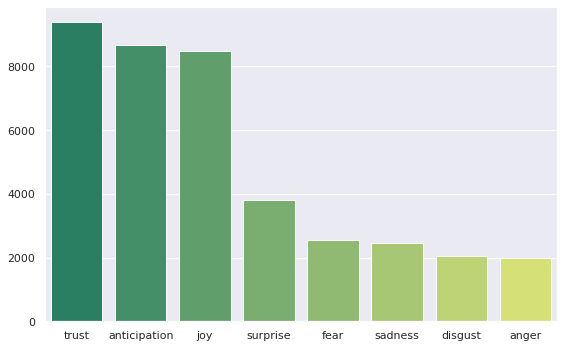

In [ ]:
# Plot barplot emotions
plt.figure(figsize=(8, 5))
emotions = counter_emotions(df_peak)
emotions = dict(sorted(emotions.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x=list(emotions.keys()), y=list(emotions.values()), palette='summer' )
plt.tight_layout()